In [33]:
# env init
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import joblib
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [ ]:
# make some changes to the dataframe (enforce, unbalanced)
# 3 train df, 1 is original, 2 is enforced, 3 is unbalanced

# unbalanced part
working_path = "./unbalanced/"

train_df = pd.read_csv("./train.csv")
val_df = pd.read_csv("./val.csv")
test_df = pd.read_csv("./test.csv")

categories = [
    d
    for d in os.listdir("./Aerial_Landscapes")
    if os.path.isdir(os.path.join("./Aerial_Landscapes", d))
]

train_df_unbalanced = (
    train_df.copy()
)  # at here, train df still same as original, the index of img and label are same as original, not in unbalanced dir

# set rules for unbalancing
major_part = [
    "Mountain",
    "River",
    "City",
    "Airport",
    "Beach",
    "Port",
    "Residential",
    "Railway",
    "Parking",
]
minor_part = [
    "Agriculture",
    "Forest",
    "Desert",
    "Lake",
    "Grassland",
    "Highway",
    "Agriculture",
]


image_unbalanced_paths = []
image_unbalanced_labels = []

# unbalance the images in the dataframe
for i in range(len(train_df_unbalanced)):
    image_path = train_df_unbalanced.iloc[i]["image_path"]
    image_label = train_df_unbalanced.iloc[i]["label"]
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error reading image {image_path}")
        continue

    # unbalance the image
    # if image_label in major_part and np.random.rand() < 0.5:
    #     print(f"Unbalancing {image_label} image {i} in major part")
    #     continue
    # elif image_label in minor_part and np.random.rand() < 0.8:
    #     print(f"Unbalancing {image_label} image {i} in minor part")
    #     continue
    # ULTRA RANDOOOOM, roll 10%-90% chance to unbalance. DONT USE MAJOR AND MINOR PARTS
    # roll a random number between 0 and 1, save the number 
    # each category : randomly unbalance 10%-90% of the images
    if np.random.rand() < 0.5:
        print(f"Unbalancing {image_label} image {i}")
        continue


    # save the unbalanced image to the dataframe
    unbalanced_image_path = os.path.join(
        working_path + "img", f"{image_label}_{i}.jpg"
    )
    # replace \ with / in the path
    unbalanced_image_path = unbalanced_image_path.replace("\\", "/")
    cv2.imwrite(unbalanced_image_path, image)# save the unbalanced image to the unbalanced directory
    image_unbalanced_paths.append(unbalanced_image_path)
    image_unbalanced_labels.append(image_label)

# add the unbalanced images to the dataframe
train_df_unbalanced = pd.DataFrame(
    {"image_path": image_unbalanced_paths, "label": image_unbalanced_labels}
)



# # copy the unbalanced images to the unbalanced directory
# for i in range(len(train_df_unbalanced)):
#     image_path = train_df_unbalanced.iloc[i]["image_path"]
#     image_label = train_df_unbalanced.iloc[i]["label"]
#     image = cv2.imread(image_path)

#     if image is None:
#         print(f"Error reading image {image_path}")
#         continue

#     # save the unbalanced image to the unbalanced directory
#     unbalanced_image_path = os.path.join(
#         working_path + "/img", f"{image_label}_{i}.jpg"
#     )
#     cv2.imwrite(unbalanced_image_path, image)

# save
train_df_unbalanced.to_csv(working_path + "/train_unbalanced.csv", index=False)
#ETA 25s

Unbalancing City image 2
Unbalancing Railway image 4
Unbalancing Residential image 7
Unbalancing River image 8
Unbalancing Beach image 9
Unbalancing Desert image 12
Unbalancing Beach image 18
Unbalancing Port image 20
Unbalancing Port image 21
Unbalancing Railway image 22
Unbalancing Grassland image 23
Unbalancing Parking image 24
Unbalancing Airport image 27
Unbalancing Residential image 28
Unbalancing Agriculture image 29
Unbalancing Residential image 30
Unbalancing City image 31
Unbalancing Forest image 32
Unbalancing Railway image 33
Unbalancing Grassland image 36
Unbalancing Forest image 37
Unbalancing Desert image 38
Unbalancing Lake image 39
Unbalancing Mountain image 40
Unbalancing Port image 44
Unbalancing Forest image 46
Unbalancing Railway image 48
Unbalancing City image 49
Unbalancing Port image 53
Unbalancing River image 55
Unbalancing Beach image 56
Unbalancing Port image 61
Unbalancing Lake image 63
Unbalancing Beach image 64
Unbalancing Grassland image 67
Unbalancing Ag

In [43]:
# show the unbalanced count of images
category_counts = train_df_unbalanced["label"].value_counts()

print(category_counts)
cate_address = train_df_unbalanced["image_path"].values
print(cate_address)

label
Airport        311
Agriculture    298
Residential    295
City           294
Lake           294
Highway        288
Parking        288
Grassland      287
Desert         286
Port           285
Railway        284
Beach          282
River          279
Mountain       260
Forest         260
Name: count, dtype: int64
['./unbalanced/img/Airport_0.jpg' './unbalanced/img/Highway_1.jpg'
 './unbalanced/img/Port_3.jpg' ... './unbalanced/img/Beach_8392.jpg'
 './unbalanced/img/Beach_8393.jpg' './unbalanced/img/Airport_8394.jpg']


In [ ]:
# SIFT for getting keypoints and descriptors
sift_unbalanced = cv2.SIFT_create()
# save sift descriptors and keypoints

sift_unbalanced_descriptors_list = []

# start sift, only on train df unbalanced
for index, row in train_df_unbalanced.iterrows():
    image_path = row["image_path"]
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift_unbalanced.detectAndCompute(gray_image, None)

    if descriptors is not None and descriptors.ndim == 2:
        sift_unbalanced_descriptors_list.append(descriptors)

# show number of keypoints and descriptors
print("###UNBALANCED TRAIN DF###")
print(f"Number of descriptors: {len(sift_unbalanced_descriptors_list)}")


# save
with open("sift_unbalanced_descriptors_list.pkl", "wb") as f:
    pickle.dump(sift_unbalanced_descriptors_list, f)
# load sift descriptors and keypoints
#ETA 1m7s

###UNBALANCED TRAIN DF###
Number of descriptors: 3126


In [ ]:
# build boW


# flatten the list of descriptors and fit kmeans
if sift_unbalanced_descriptors_list:
    all_descriptors = np.vstack(sift_unbalanced_descriptors_list)
k = 300  # number of clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
kmeans.fit(all_descriptors)

def get_bow_histogram(descriptors, kmeans):
    if descriptors is not None:
        # predict the cluster for each descriptor
        cluster_indices = kmeans.predict(descriptors)
        # count the occurrences of each cluster index
        histogram, _ = np.histogram(cluster_indices, bins=np.arange(k + 1), density=True)
        return histogram
    else:
        # if descriptors is None, return a zero histogram
        return np.zeros(k)
    
def get_bow_features(dataframe,image_path, kmeans):
    x_temp= []
    y_temp= []

    for index, row in dataframe.iterrows():
        image_path = row['image_path']
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift_unbalanced.detectAndCompute(gray_image, None)

        # get the histogram for the image
        histogram = get_bow_histogram(descriptors, kmeans)

        x_temp.append(histogram)
        y_temp.append(row['label'])
    return np.array(x_temp), np.array(y_temp)

x_train = []
y_train = []

for index, row in train_df_unbalanced.iterrows():
    image_path = row['image_path']
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift_unbalanced.detectAndCompute(gray_image, None)

    # get the histogram for the image
    histogram = get_bow_histogram(descriptors, kmeans)

    x_train.append(histogram)
    y_train.append(row['label'])

# convert to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val, y_val = get_bow_features(val_df, image_path, kmeans)
x_test, y_test = get_bow_features(test_df, image_path, kmeans)



# ETA 3m2s

d:\Dev\anaconda3\envs\SIFT_KNN\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [38]:
# save to disk
np.save(working_path + 'x_train.npy', x_train)
np.save(working_path + 'y_train.npy', y_train)
np.save(working_path + 'x_val.npy', x_val)
np.save(working_path + 'y_val.npy', y_val)
np.save(working_path + 'x_test.npy', x_test)
np.save(working_path + 'y_test.npy', y_test)

In [39]:
# start training, by KNN


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

# test the model on test set
y_pred = knn.predict(x_test)

# try on validation set
y_val_pred = knn.predict(x_val)

# save knn model
joblib.dump(knn, working_path + 'knn_model.pkl')
# save y_pred and y_val_pred
np.save(working_path + 'y_pred.npy', y_pred)
np.save(working_path + 'y_val_pred.npy', y_val_pred)
# save y_test and y_val
np.save(working_path + 'y_test.npy', y_test)
np.save(working_path + 'y_val.npy', y_val)

Accuracy: 0.44
              precision    recall  f1-score   support

 Agriculture       0.52      0.28      0.36       120
     Airport       0.24      0.48      0.32       120
       Beach       0.50      0.22      0.30       120
        City       0.29      0.88      0.44       120
      Desert       0.69      0.20      0.31       120
      Forest       0.69      0.81      0.74       120
   Grassland       0.69      0.26      0.38       120
     Highway       0.53      0.17      0.26       120
        Lake       0.35      0.10      0.16       120
    Mountain       0.44      0.81      0.57       120
     Parking       0.84      0.71      0.77       120
        Port       0.61      0.19      0.29       120
     Railway       0.43      0.78      0.55       120
 Residential       0.52      0.55      0.54       120
       River       0.31      0.20      0.24       120

    accuracy                           0.44      1800
   macro avg       0.51      0.44      0.42      1800
weighted av

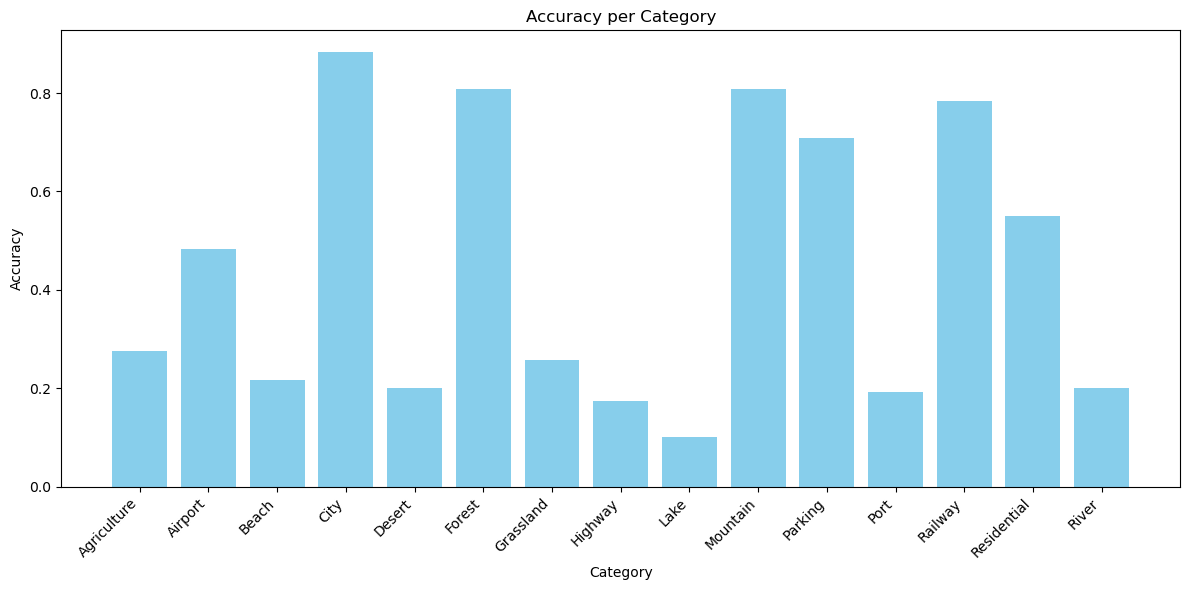

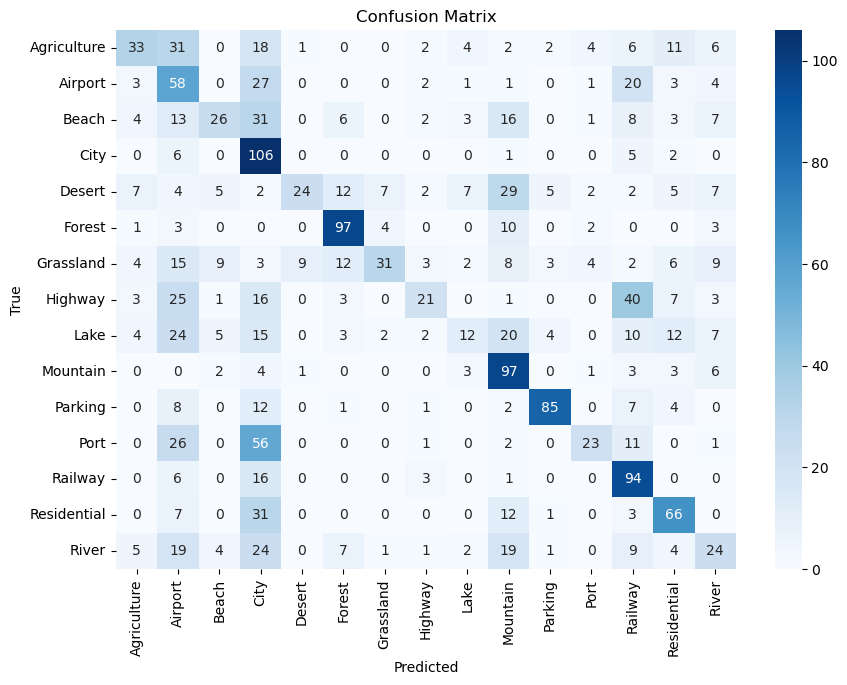

In [40]:
# show results by plt


# show accuracy
accuracy = accuracy_score(y_test, y_pred)  
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred, target_names=categories))

# show accuracy by each cateq,using bar chart via plt
# x axis 
# y axis accuracy

accuracy_per_class = {}
for i, category in enumerate(categories):
    accuracy_per_class[category] = {
        'accuracy': accuracy_score(y_test[y_test == category], y_pred[y_test == category]),
        'precision': classification_report(y_test, y_pred, target_names=categories, output_dict=True)[category]['precision'],
        'recall': classification_report(y_test, y_pred, target_names=categories, output_dict=True)[category]['recall']
    }
accuracy_df = pd.DataFrame(accuracy_per_class).T
accuracy_df = accuracy_df.sort_values(by='accuracy', ascending=False)
accuracy_df = accuracy_df.reset_index()
accuracy_df.columns = ['Category', 'Accuracy', 'Precision', 'Recall']
accuracy_df['Category'] = pd.Categorical(accuracy_df['Category'], categories=categories, ordered=True)
accuracy_df = accuracy_df.sort_values('Category')
plt.figure(figsize=(12, 6))
plt.bar(accuracy_df['Category'], accuracy_df['Accuracy'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.title('Accuracy per Category')
plt.tight_layout()
plt.show()


# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Validation Accuracy:  0.4677777777777778
              precision    recall  f1-score   support

 Agriculture       0.56      0.33      0.42       120
     Airport       0.28      0.53      0.36       120
       Beach       0.57      0.29      0.39       120
        City       0.30      0.83      0.44       120
      Desert       0.65      0.25      0.36       120
      Forest       0.78      0.88      0.83       120
   Grassland       0.69      0.32      0.43       120
     Highway       0.55      0.18      0.28       120
        Lake       0.42      0.09      0.15       120
    Mountain       0.47      0.83      0.60       120
     Parking       0.88      0.63      0.74       120
        Port       0.82      0.35      0.49       120
     Railway       0.38      0.72      0.50       120
 Residential       0.48      0.56      0.52       120
       River       0.30      0.21      0.25       120

    accuracy                           0.47      1800
   macro avg       0.54      0.47      

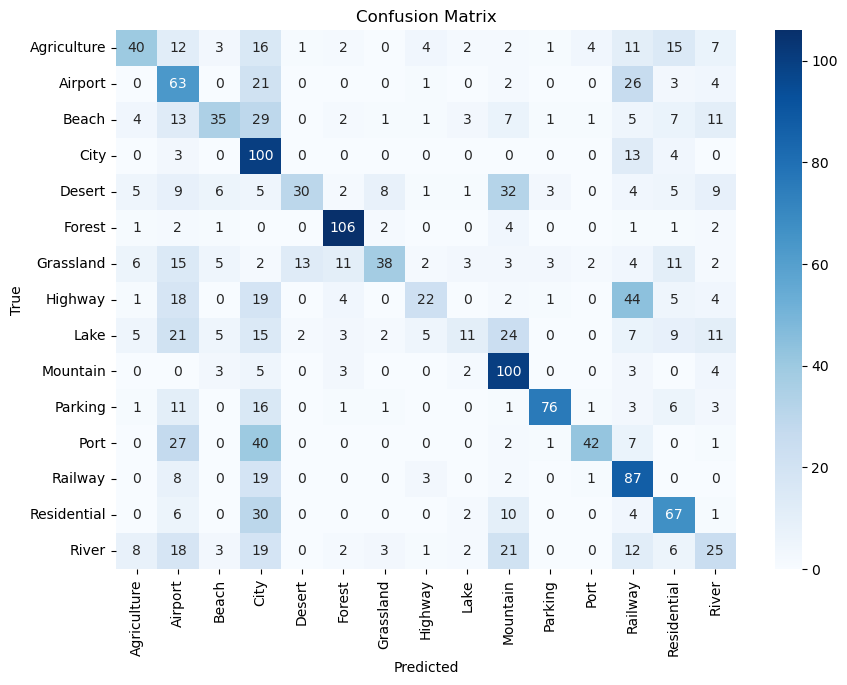

In [41]:
# val results
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=categories))
# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_val, y_val_pred, labels=categories)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
